In [15]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from anndata import AnnData
import os
from os.path import join 
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# # This file contains all the cells 
# df_design = pd.read_csv(join(DATA_PATH, 'GSE84498_experimental_design.txt.gz'), sep='\t')
# df_design.index = df_design['well']
# df_data = pd.read_csv(join(DATA_PATH, 'GSE84498_umitab.txt.gz'), sep='\t', index_col=0)

# # Make anndata 
# adata_raw = AnnData(X=df_data.T)
# adata_raw.X = sp.sparse.csr_matrix(adata_raw.X)
# adata_raw.obs = adata_raw.obs.join(df_design)
# print('# Before filtering', adata_raw.shape)

# sc.pp.filter_genes(adata_raw, min_cells=10)
# print('# After filtering', adata_raw.shape)
# adata_raw.write(DATA_PATH+'/obj_raw_full.h5ad')

... storing 'batch' as categorical
... storing 'seq_batch_ID' as categorical
... storing 'plate_coordinates' as categorical
... storing 'pool_barcode' as categorical
... storing 'cell_barcode' as categorical


# Before filtering (1736, 27389)
# After filtering (1736, 11212)


In [16]:
# Read data: this file contains only hepatocytes 
DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/mouse_liver_halpern_nature_2017'
df_data = pd.read_csv(join(DATA_PATH, 'SuppTable1_umi.zip'), sep='\s\s+', skiprows=1, index_col=0)
df_lobule = pd.read_excel(join(DATA_PATH, 'SuppTable2_lobule.xlsx'), index_col=0, skiprows=1)
df_zonation = pd.read_excel(join(DATA_PATH, 'SuppTable3_zonation.xlsx'), index_col=0, skiprows=2)

/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# Make anndata 
adata_raw = AnnData(X=df_data.T)
adata_raw.X = sp.sparse.csr_matrix(adata_raw.X)
adata_raw.obs['n_genes'] = (adata_raw.X>0).sum(axis=1)
temp_df = df_lobule.copy()
temp_df.index = [x.replace(' ','') for x in temp_df.index]
adata_raw.obs = adata_raw.obs.join(temp_df)
adata_raw.var = adata_raw.var.join(df_zonation)
print('# Before filtering', adata_raw.shape)

sc.pp.filter_genes(adata_raw, min_cells=10)
print('# After filtering', adata_raw.shape)
adata_raw.write(DATA_PATH+'/obj_raw.h5ad')

# Before filtering (1415, 27297)
# After filtering (1415, 10299)


In [22]:
# Make .cov file 
df_cov = pd.DataFrame(index=adata_raw.obs.index)
df_cov['const'] = 1
df_cov['n_genes'] = (adata_raw.X>0).sum(axis=1)
df_cov.to_csv(DATA_PATH+'/halpern_nature_2017.cov', sep='\t')

In [25]:
# Cluster the data to have UMAP plot 
adata = adata_raw.copy()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
print(adata.shape)

sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5, 
                            min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
sc.pp.scale(adata, max_value=10, zero_center=False)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.louvain(adata, resolution = 0.5)
sc.tl.leiden(adata, resolution = 0.5)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
adata.write(DATA_PATH+'/obj_processed.h5ad')

(1415, 10299)


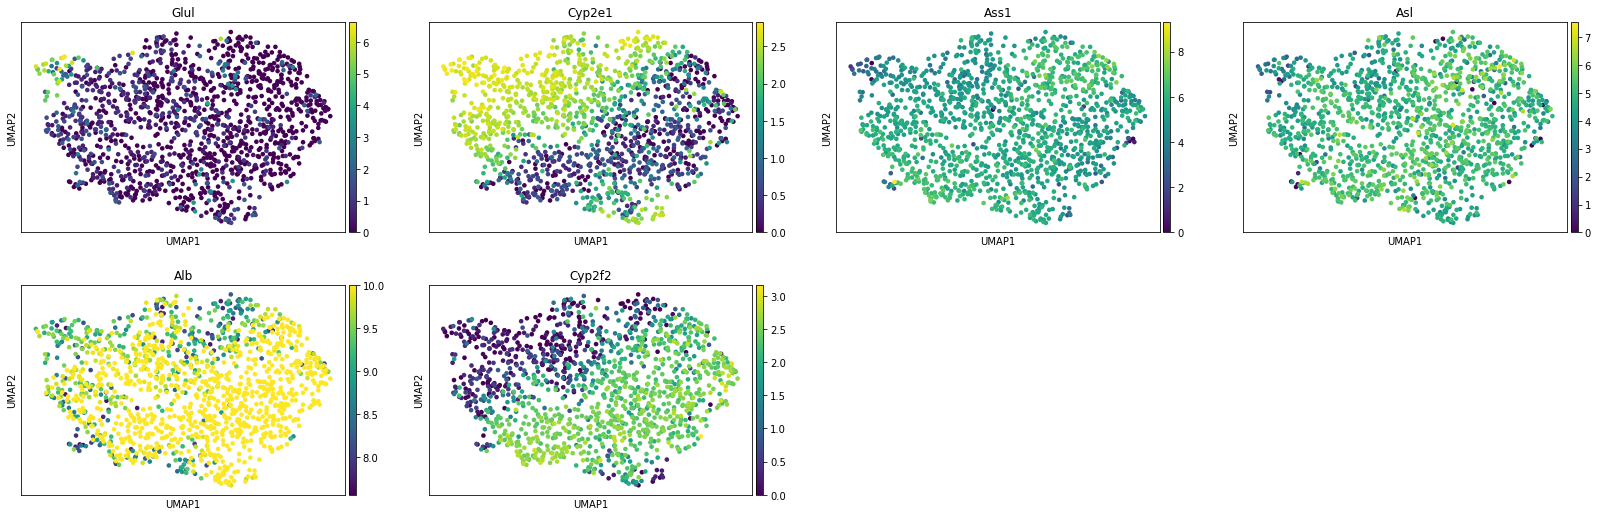

In [26]:
sc.pl.umap(adata, color=['Glul', 'Cyp2e1', 'Ass1', 'Asl', 'Alb', 'Cyp2f2'])

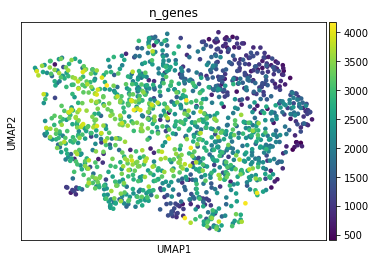

In [14]:
sc.pl.umap(adata, color=['n_genes'])